# Vertex Extensions Staying in R(K<sub>m</sub>, J<sub>n</sub>)

Based on the vertex extension method in the [R(4,5) paper](https://www.cs.rit.edu/~spr/PUBL/paper32.pdf). This notebook will contain the function for extending a graph in R(K<sub>m</sub>, J<sub>n</sub>) by one vertex, while staying in R(K<sub>m</sub>, J<sub>n</sub>).

First, we define a class to represent Intervals as described on page 4 of the R(4,5) paper.

In [1]:
class Interval:
    
    # Construct a new interval with bottom_verts as the bottom and top_verts as the top
    def __init__(self, bottom_verts, top_verts):
        self.bottom = bottom_verts
        self.top = top_verts
        
    # Get interval as a string
    def __str__(self):
        as_string = "{"
        for vert in self.bottom:
            as_string += str(vert) + ","
        as_string += "}, {"
        for vert in self.top:
            as_string += str(vert) + ","
        as_string += "}"
        return as_string

We can now move on to the actual vertex extension function. This is based on the pseudocode given on page 9 of the R(4,5) paper.

In [2]:
import copy, itertools

# Finds all possible one vertex extensions to G while staying in R(Km,Jn)
# INPUT: a graph G to be extended, m the undesired clique size and n the undesired independent set (plus one edge) size
# OUTPUT: a set of intervals whose union forms every possible neighborhood of the new vertex
def find_extensions(G, m, n):
    
    # Helper function to find Kn-e
    def j_set_helper(G, n):
        j_list = list()
        potential_js = itertools.combinations(G.vertices(), n - 1)
        for j in potential_js:
            numEdges = 0
            for pair in itertools.combinations(j, 2):
                if G.has_edge(pair[0], pair[1]):
                    numEdges += 1
            if numEdges == 1:
                j_list.append(list(j))
        return j_list
        
    
    # Get cliques and independent sets of desired size
    clique_list = list(sage.graphs.cliquer.all_cliques(G, m - 1, m - 1))
    ind_set_list = list(sage.graphs.cliquer.all_cliques(G.complement(), n - 1, n - 1))
    j_set_list = j_set_helper(G, n)
    
#     print(clique_list)
#     print(ind_set_list)
#     print(j_set_list)

    # TODO: merge clique_list, ind_set_list, and j_set)list and order them based on the description in the R(4,5) paper
    
    # Create initial interval
    viable_intervals = [Interval([],G.vertices())]
    
    # Iterate through the cliques
    for clique in clique_list:
        
        clique_as_set = set(clique)
        new_intervals = viable_intervals.copy()
        
        for interval in viable_intervals:
            # Check if we need to worry about the current interval
            # Note that if this is false, one of the vertices from the clique 
            #   is never included in the neighborhoods corresponding to this interval
            if clique_as_set.issubset(interval.top):
                
                # We always remove the given interval
                new_intervals.remove(interval)
                # Check if we need to find replacements
                if not clique_as_set.issubset(interval.bottom):
                    
                    # Find Xi - B
                    ys = []
                    for vert in clique:
                        if not vert in interval.bottom:
                            ys.append(vert)
                            
                    # Find replacement intervals and add them to the list
                    for j in range(0, len(ys)):
                        # Create copy of bottom and top
                        new_bottom = []
                        new_top = []
                        for vert in interval.bottom:
                            new_bottom.append(vert)
                        for vert in interval.top:
                            # Don't include yj into the top
                            if not vert == ys[j]:
                                new_top.append(vert)
                        # Add y1,...,yj-1 elements to the bottom
                        for k in range(0, j):
                            new_bottom.append(ys[k])
                        # Add our new interval to the list
                        new_intervals.append(Interval(new_bottom, new_top))
        # Replace the old list of intervals with our new list of intervals
        viable_intervals = new_intervals
        
        
    # Iterate through the independent sets
    # This is a special case for R(Km,Jn) 
    for ind_set in ind_set_list:
        
        ind_set_as_set = set(ind_set)
        new_intervals = viable_intervals.copy()
        
        for interval in viable_intervals:
            # Check if we need to worry about the current interval
            # Note: We split this into two cases:
            #   - When the bottom and independent set don't intersect
            #      - We need to add at least two vertices from the independent set to the bottom
            #   - When there is exactly one vertex in the intersection of the bottom and independent set
            #      - We only need to add one additional vertex from the independent set to the bottom
            if len(ind_set_as_set & set(interval.bottom)) == 0:
                
                # We always remove the given interval
                new_intervals.remove(interval)
                # Check if we need to find replacements
                if len(ind_set_as_set & set(interval.top)) >= 2:
                    # Find Xi intersect T
                    ys = []
                    for vert in ind_set:
                        if vert in interval.top:
                            ys.append(vert)
                            
                    # Take every pair of vertices from the independent set
                    y_pairs = itertools.combinations(range(0,len(ys)), 2)
                    # Find replacement intervals and add them to the list
                    for pair in y_pairs:
                        # Create copies of bottom and top
                        new_bottom = []
                        new_top = []
                        for vert in interval.bottom:
                            new_bottom.append(vert)
                        # Add pair to bottom
                        new_bottom.append(ys[pair[0]])
                        new_bottom.append(ys[pair[1]])
                        for vert in interval.top:
                            new_top.append(vert)
                        # Remove all vertices in the independent set up to (and in between) the current pair from the top
                        for k in range(0, pair[0]):
                            new_top.remove(ys[k])
                        for k in range(pair[0]+1, pair[1]):
                            new_top.remove(ys[k])
                        new_intervals.append(Interval(new_bottom, new_top))
                        
                        
            elif len(ind_set_as_set & set(interval.bottom)) == 1:
                # We always remove the given interval
                new_intervals.remove(interval)
                # Check if we need to find replacements
                if len(ind_set_as_set & set(interval.top)) >= 2:
                    # Find Xi intersect T (but not the vertex already in the bottom)
                    ys = []
                    for vert in ind_set:
                        if vert in interval.top and not vert in interval.bottom:
                            ys.append(vert)
                    
                    # Find replacement intervals and add them to the list
                    for j in range(0,len(ys)):
                        # Create copies of bottom and top
                        new_bottom = []
                        new_top = []
                        for vert in interval.bottom:
                            new_bottom.append(vert)
                        # Add yj to bottom
                        new_bottom.append(ys[j])
                        for vert in interval.top:
                            new_top.append(vert)
                        # Remove all vertices up to yj from the top
                        for k in range(0, j):
                            new_top.remove(ys[k])
                        new_intervals.append(Interval(new_bottom, new_top))
                        
        # Replace the old list of intervals with the new list of intervals
        viable_intervals = new_intervals
            
            
            
    # Iterate through the list of Js
    # Same logic as for independent sets in the Km,Kn case
    for j_set in j_set_list:
        
        j_set_as_set = set(j_set)
        new_intervals = viable_intervals.copy()
        
        for interval in viable_intervals:
            # Checks if the intersection of current J and B is empty
            # Note that if this is false one of the vertices from the Jn-1 is already in the interval, so we can skip
            if not j_set_as_set & set(interval.bottom):
                # We always remove the given interval
                new_intervals.remove(interval)
                # Check if we need to find replacements
                if j_set_as_set & set(interval.top):
                    # Find Xi intersect T
                    ys = []
                    for vert in j_set:
                        if vert in interval.top:
                            ys.append(vert)
                            
                    # Find replacement intervals and add them to the list
                    for j in range(0, len(ys)):
                        # Create copies of bottom and top
                        new_bottom = []
                        new_top = []
                        for vert in interval.bottom:
                            new_bottom.append(vert)
                        # Add yj to bottom
                        new_bottom.append(ys[j])
                        for vert in interval.top:
                            new_top.append(vert)
                        # Remove y1,...,yj-1 from top
                        for k in range(0, j):
                            new_top.remove(ys[k])
                        new_intervals.append(Interval(new_bottom, new_top))
        # Replace the old list of intervals with the new list of intervals
        viable_intervals = new_intervals
    
    return viable_intervals

Some basic tests of the method:

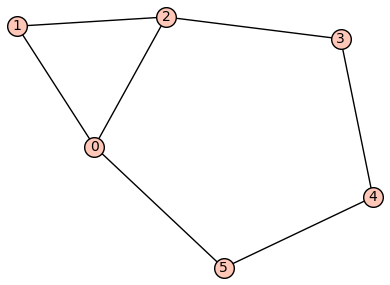

{0,1,5,}, {0,1,4,5,}
{3,5,4,}, {2,3,4,5,}
{1,3,2,}, {1,2,3,4,5,}
{1,3,4,}, {1,3,4,5,}
{1,5,4,}, {1,4,5,}
{1,5,2,4,}, {1,2,4,5,}
{0,3,5,2,}, {0,2,3,4,5,}
{0,3,5,4,}, {0,3,4,5,}
{0,1,3,4,}, {0,1,3,4,5,}
{0,1,3,5,}, {0,1,3,5,}


In [3]:
G = graphs.EmptyGraph()
for i in range(0, 5):
    G.add_edge(i, i+1)
G.add_edge(0, 5)
G.add_edge(0, 2)
#G.add_edge(3, 5)
G.show()
extensions = find_extensions(G, 4, 4)
for interval in extensions:
    print(str(interval))

Now that we have the possible neighborhoods for the new vertex, we define a function converting an interval into the graphs it represents.

In [4]:
import itertools

# Adds a vertex to G based on the given interval
# INPUT: a graph G and an interval of corresponding vertices that are viable neighborhoods for a new vertex v
# OUTPUT: a list of graphs that are G with a vertex added
def add_vertex(G, interval):
    
    finished_graphs = []
    bottom = interval.bottom
    top_not_in_bottom = []
    
    for vertex in interval.top:
        if not vertex in bottom:
            top_not_in_bottom.append(vertex)
    
    def recursive_search(G, bottom, top_not_in_bottom, neighborhood_size):
        
        #print(bottom, top_not_in_bottom, neighborhood_size)
        
        missing_spots = neighborhood_size - len(bottom)
        
        for missing_comb in itertools.combinations(top_not_in_bottom, missing_spots):
            
            neighborhood = bottom + list(missing_comb)
            
            new_G = G.copy()
            
            for vert in neighborhood:
                
                new_G.add_edge("v", vert)
                
            finished_graphs.append(new_G)
            
        if not len(bottom) + len(top_not_in_bottom) == neighborhood_size:
            recursive_search(G, bottom, top_not_in_bottom, neighborhood_size + 1)
    
    recursive_search(G, bottom, top_not_in_bottom, len(bottom))
    
    return finished_graphs

Testing this new function:

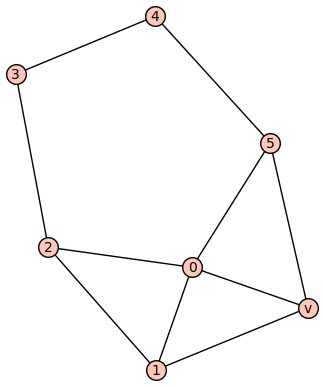

3
3
No J4


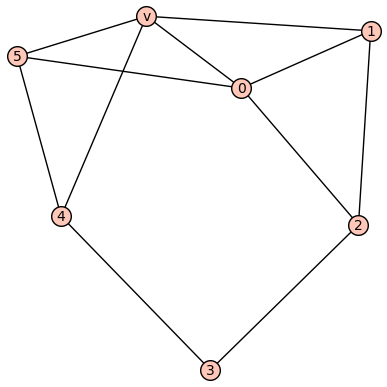

3
3
No J4


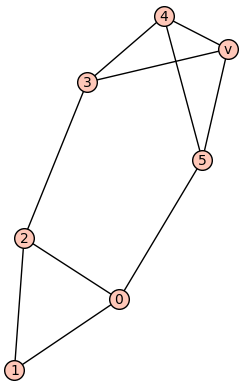

3
3
No J4


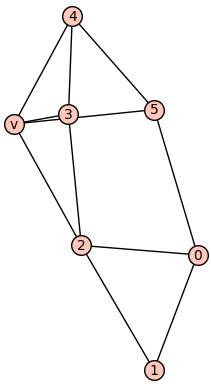

3
3
No J4


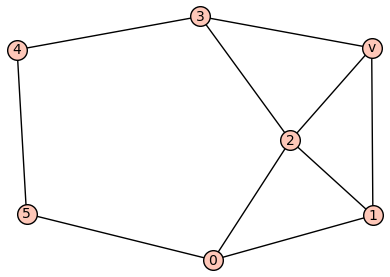

3
3
No J4


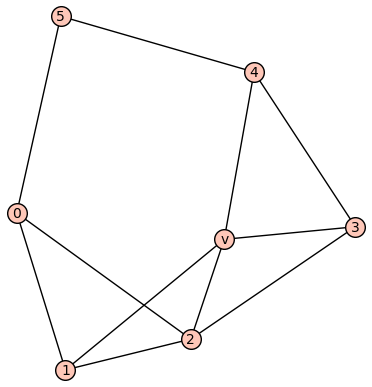

3
3
No J4


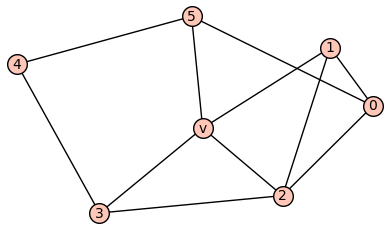

3
3
No J4


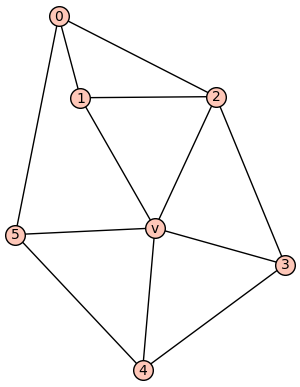

3
3
No J4


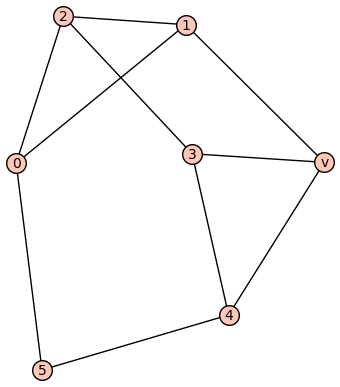

3
3
No J4


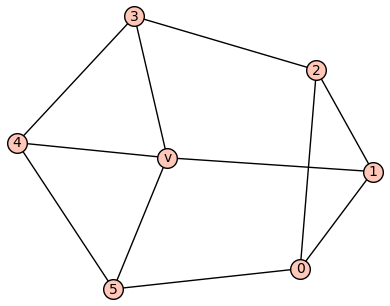

3
3
No J4


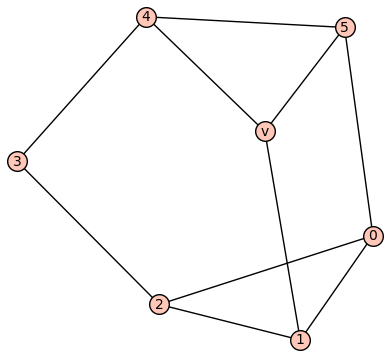

3
3
No J4


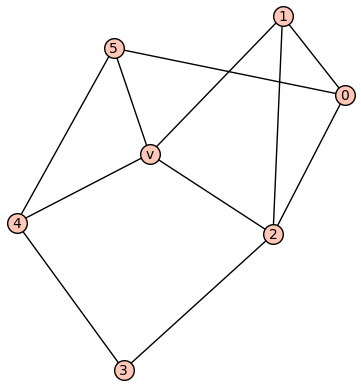

3
3
No J4


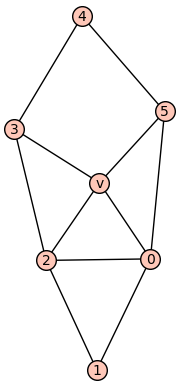

3
3
No J4


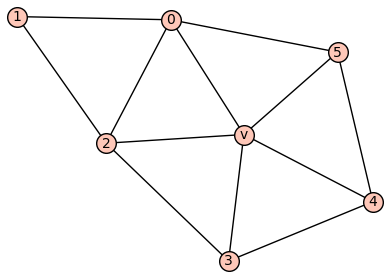

3
3
No J4


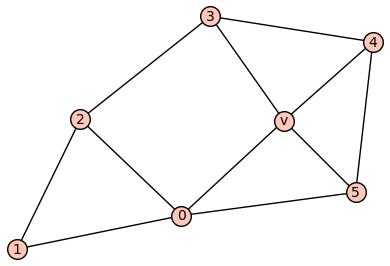

3
3
No J4


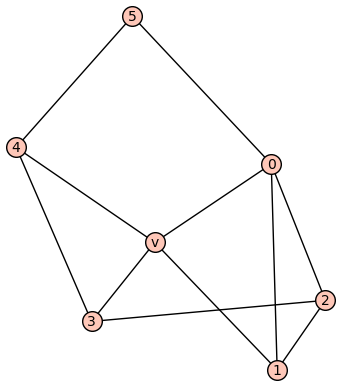

3
3
No J4


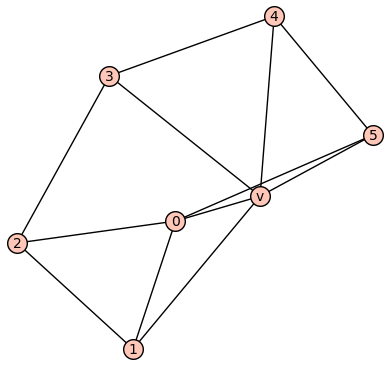

3
3
No J4


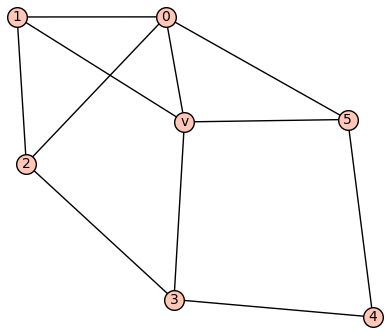

3
3
No J4


In [5]:
extended_graphs = []

for i in range(0, len(extensions)):
    new_graphs = add_vertex(G, extensions[i])

    for graph in new_graphs:
        extended_graphs.append(graph)
        
for graph in extended_graphs:
    graph.show()
    print(graph.clique_number())
    print(graph.complement().clique_number())
    potential_js = itertools.combinations(graph.vertices(sort=False), 4)
    has_j = false
    for j in potential_js:
        numEdges = 0
        for pair in itertools.combinations(j, 2):
            if graph.has_edge(pair[0], pair[1]):
                numEdges += 1
        if numEdges == 1:
            has_j = true
    if has_j:
        print("Contains J4")
    else:
        print("No J4")

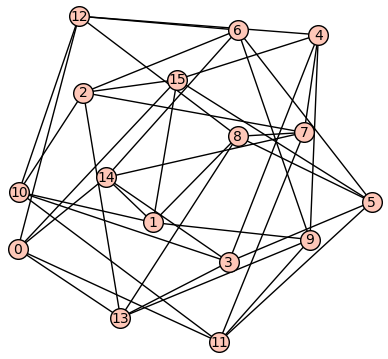

0


In [6]:
from sage.graphs.graph_input import from_graph6
order16_graph = Graph()
with open('k3k6e_16.g6', 'r') as file: # Opens the file, and closes it once we exit this block. 
    imported_graphs = file.readlines() 
    G = Graph()
    from_graph6(G, imported_graphs[0])
    G = G.complement()
    order16_graph = G
    G.show()
    extensions = find_extensions(G, 3, 6)
    print(len(extensions))
    for interval in extensions:
        print(str(interval))

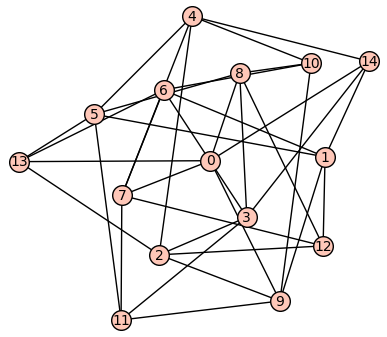

1
{12,13,11,14,10,}, {10,11,12,13,14,}


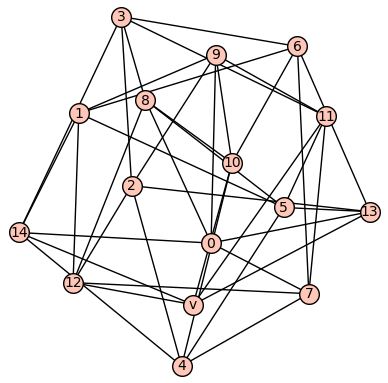

2
5
No J6


In [7]:
extended_graphs = []

order15_graph = Graph()
with open('k3k6e_15.g6', 'r') as file: # Opens the file, and closes it once we exit this block. 
    imported_graphs = file.readlines() 
    G = Graph()
    from_graph6(G, imported_graphs[0])
    G = G.complement()
    order15_graph = G
    G.show()
    extensions = find_extensions(G, 3, 6)
    print(len(extensions))
    for interval in extensions:
        print(str(interval))
        new_graphs = add_vertex(G, interval)
        for graph in new_graphs:
            extended_graphs.append(graph)
            
for graph in extended_graphs:
    graph.show()
    print(graph.clique_number())
    print(graph.complement().clique_number())
    potential_js = itertools.combinations(graph.vertices(sort=False), 6)
    has_j = false
    for j in potential_js:
        numEdges = 0
        for pair in itertools.combinations(j, 2):
            if graph.has_edge(pair[0], pair[1]):
                numEdges += 1
        if numEdges == 1:
            has_j = true
    if has_j:
        print("Contains J6")
    else:
        print("No J6")

In [8]:
for graph in extended_graphs:
    print(order16_graph.is_isomorphic(graph))

True


In [9]:
extended_graphs = []

with open('k3k6e_14.g6', 'r') as file: # Opens the file, and closes it once we exit this block. 
    imported_graphs = file.readlines()
    for i in range(0, len(imported_graphs)):
        print("Graph: ", i)
        G = Graph()
        from_graph6(G, imported_graphs[i])
        G = G.complement()
#         G.show()
        extensions = find_extensions(G, 3, 6)
        print(len(extensions))
        for interval in extensions:
            print(str(interval))
        if len(extensions) > 0:
            for extension in extensions:
                new_graphs = add_vertex(G, extension)
                for graph in new_graphs:
                    extended_graphs.append(graph)
        
for graph in extended_graphs:
    graph.show()
    print(graph.clique_number())
    print(graph.complement().clique_number())
    potential_js = itertools.combinations(graph.vertices(sort=False), 6)
    has_j = false
    for j in potential_js:
        numEdges = 0
        for pair in itertools.combinations(j, 2):
            if graph.has_edge(pair[0], pair[1]):
                numEdges += 1
        if numEdges == 1:
            has_j = true
    if has_j:
        print("Contains J6")
    else:
        print("No J6")

SyntaxError: unmatched ')' (4280607958.py, line 4)

In [ ]:
for graph in extended_graphs:
    print(order15_graph.is_isomorphic(graph))